In [ ]:
# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, lit, avg
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.linalg import Vectors

# Data manipulation & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn and imbalanced-learn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

# ML libraries
from lightgbm import LGBMClassifier

# Statistical tests
from scipy.stats import chi2_contingency, kruskal

# Experiment tracking
import mlflow

# Databricks AutoML
from databricks import automl

**EDA**

In [ ]:
df = spark.table("hive_metastore.default.digital_marketing_campaign_dataset_csv")

In [0]:
display(df.limit(5))

CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
8000,56,Female,136912.0,Social Media,Awareness,6497.87,0.04391851,0.08803141,0,2.3990166,7.3968024,19,6,9,4,688,IsConfid,ToolConfid,true
8001,69,Male,41760.0,Email,Retention,3898.6687,0.15572508,0.18272468,42,2.9171379,5.3525486,5,2,7,2,3459,IsConfid,ToolConfid,true
8002,46,Female,88456.0,PPC,Awareness,1546.4296,0.27749038,0.07642272,2,8.223619,13.794902,0,11,2,8,2337,IsConfid,ToolConfid,true
8003,32,Female,44085.0,PPC,Conversion,539.52594,0.13761126,0.08800419,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,true
8004,60,Female,83964.0,PPC,Conversion,1678.0436,0.2528511,0.109940104,0,2.046847,13.99337,6,6,6,8,4345,IsConfid,ToolConfid,true


In [0]:
df = df.withColumn('Conversion', col('Conversion').cast('integer'))

display(df.limit(5))

CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
8000,56,Female,136912.0,Social Media,Awareness,6497.87,0.04391851,0.08803141,0,2.3990166,7.3968024,19,6,9,4,688,IsConfid,ToolConfid,1
8001,69,Male,41760.0,Email,Retention,3898.6687,0.15572508,0.18272468,42,2.9171379,5.3525486,5,2,7,2,3459,IsConfid,ToolConfid,1
8002,46,Female,88456.0,PPC,Awareness,1546.4296,0.27749038,0.07642272,2,8.223619,13.794902,0,11,2,8,2337,IsConfid,ToolConfid,1
8003,32,Female,44085.0,PPC,Conversion,539.52594,0.13761126,0.08800419,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
8004,60,Female,83964.0,PPC,Conversion,1678.0436,0.2528511,0.109940104,0,2.046847,13.99337,6,6,6,8,4345,IsConfid,ToolConfid,1


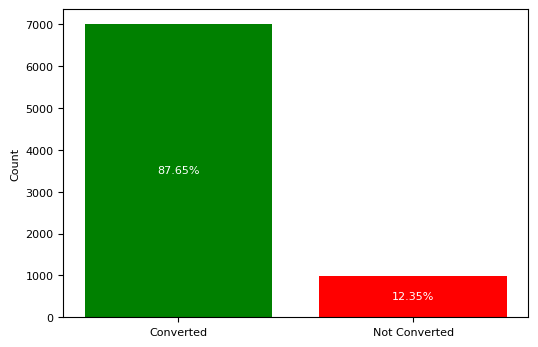

In [0]:
conversion_counts = df.groupBy("Conversion").agg(count(lit(1)).alias("Count"))

# Calculate the total count
total_count = df.count()

# Convert counts to percentages for labeling
conversion_counts = conversion_counts.withColumn("Percentage", (col("Count") / lit(total_count) * 100))

# Convert Spark DataFrame to Pandas DataFrame for visualization
conversion_pd = conversion_counts.toPandas()

# Plotting
plt.figure(figsize=(6, 4))
bars = plt.bar(x=conversion_pd['Conversion'].astype(str), height=conversion_pd['Count'], color=['green', 'red'])

# Adding percentage labels in the middle of bars
for bar, percentage in zip(bars, conversion_pd['Percentage']):
    y_position = bar.get_height() / 2  # Calculate the middle position
    plt.text(bar.get_x() + bar.get_width() / 2, y_position, f'{percentage:.2f}%', ha='center', va='center',color='white')

plt.ylabel('Count')

plt.xticks(ticks=[0, 1], labels=['Converted', 'Not Converted'])
plt.show()

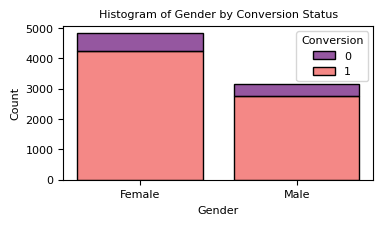

In [0]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(4, 2))

# Plotting the histogram using seaborn
sns.histplot(data=df.toPandas(), x='Gender', hue='Conversion', multiple='stack', shrink=0.8,  palette='magma')

# Adding labels and title
plt.xlabel('Gender', fontsize=8)
plt.ylabel('Count', fontsize = 8)
plt.title('Histogram of Gender by Conversion Status', fontsize=8)

# Show the plot
plt.show()

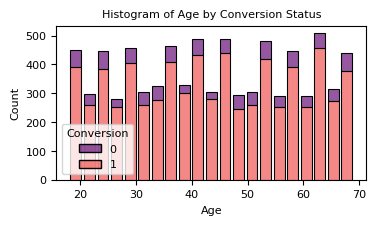

In [0]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(4, 2))

# Plotting the histogram using seaborn
sns.histplot(data=df.toPandas(), x='Age', hue='Conversion', multiple='stack', shrink=0.8,  palette='magma')

# Adding labels and title
plt.xlabel('Age', fontsize=8)
plt.ylabel('Count', fontsize = 8)
plt.title('Histogram of Age by Conversion Status', fontsize=8)

# Show the plot
plt.show()

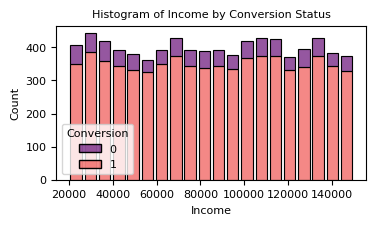

In [0]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(4, 2))

# Plotting the histogram using seaborn
sns.histplot(data=df.toPandas(), x='Income', hue='Conversion', multiple='stack', shrink=0.8,  palette='magma')

# Adding labels and title
plt.xlabel('Income', fontsize=8)
plt.ylabel('Count', fontsize = 8)
plt.title('Histogram of Income by Conversion Status', fontsize=8)

# Show the plot
plt.show()

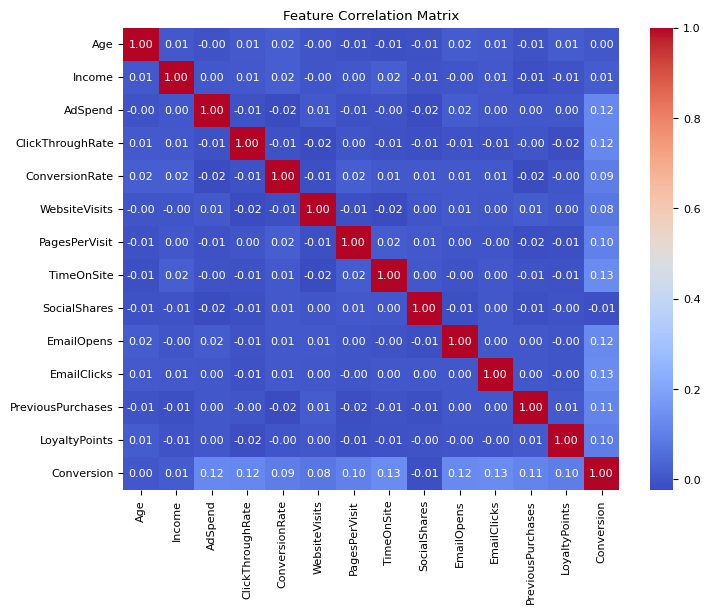

In [0]:
# List of columns you want to include in the correlation matrix
columns_to_include = ['Age', 'Income', 'AdSpend', 'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints','Conversion']

# Assemble the vector
assembler = VectorAssembler(inputCols=columns_to_include, outputCol="features")
df_vector = assembler.transform(df).select("features")

# Calculate Pearson correlation matrix
corr_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()

# Convert to Pandas DataFrame for plotting
corr_df = pd.DataFrame(corr_matrix, index=columns_to_include, columns=columns_to_include)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

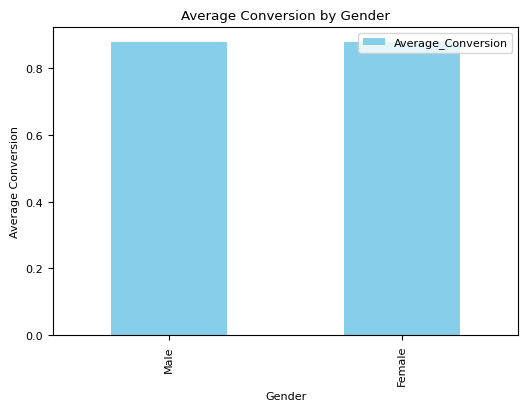

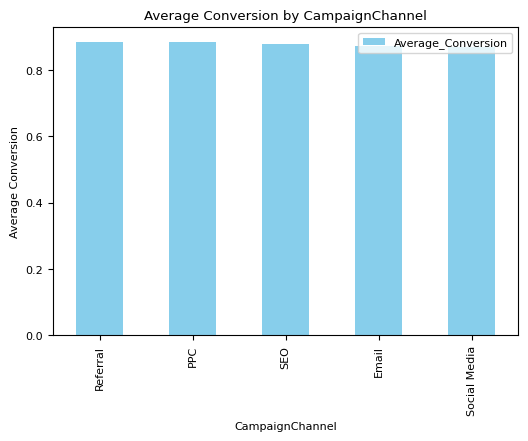

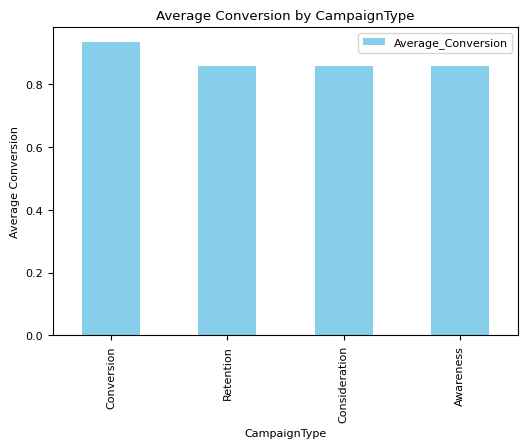

In [0]:

categorical_columns = [item[0] for item in df.dtypes if item[1].startswith('string') and item[0] not in ['CustomerID', 'AdvertisingTool', 'AdvertisingPlatform']]

for column in categorical_columns:
    result_df = df.groupBy(column).agg(avg(col("Conversion")).alias("Average_Conversion")).orderBy("Average_Conversion", ascending=False)
    result_pd = result_df.toPandas()
    result_pd.plot(kind='bar', x=column, y='Average_Conversion', color='skyblue', figsize=(6, 4))
    plt.title(f'Average Conversion by {column}')
    plt.ylabel('Average Conversion')
    plt.xlabel(column)
    display()  # Use display() to show the plot in Databricks

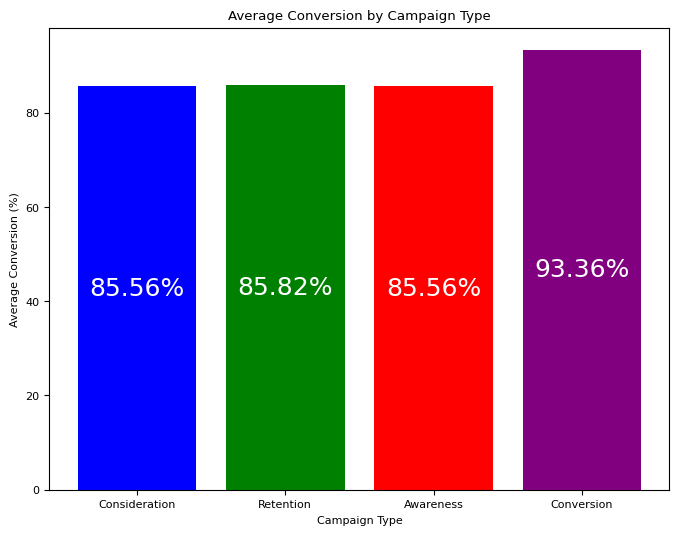

In [0]:

# Calculate average conversion by CampaignType
avg_conversion_df = df.groupBy("CampaignType").agg(avg(col("Conversion")).alias("Average_Conversion"))

# Multiply by 100 to convert to percentage
avg_conversion_df = avg_conversion_df.withColumn("Average_Conversion", col("Average_Conversion") * 100)

# Convert to Pandas for plotting
avg_conversion_pd = avg_conversion_df.toPandas()

# Define a list of colors for the bars
colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']

# Ensure the list of colors is at least as long as the number of unique campaign types
unique_campaign_types = avg_conversion_pd['CampaignType'].nunique()
if len(colors) < unique_campaign_types:
    print("Warning: Not enough colors specified for each campaign type. Some bars will have the same color.")

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(x=avg_conversion_pd['CampaignType'], height=avg_conversion_pd['Average_Conversion'], color=colors)

plt.title('Average Conversion by Campaign Type')
plt.ylabel('Average Conversion (%)')
plt.xlabel('Campaign Type')

# Adding the percentage labels in the middle of the bars, rounded to the nearest hundredth
for bar, value in zip(bars, avg_conversion_pd['Average_Conversion']):
    y_position = bar.get_height() / 2  # Calculate the middle position
    plt.text(bar.get_x() + bar.get_width() / 2, y_position, f'{value:.2f}%', ha='center', va='center', color='white', fontsize=18)

display()  # Use display() to show the plot in Databricks

**Feature Selection**

In [0]:
target_column = 'Conversion'

In [0]:
# Indexing categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed").fit(df) for column in categorical_columns]

# Creating a pipeline to transform the data
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df).transform(df)

# Assembling indexed columns into a single vector column
assembler = VectorAssembler(inputCols=[column+"_indexed" for column in categorical_columns], outputCol="features")
df_assembled = assembler.transform(df_indexed)

# Performing Chi-Squared test
r = ChiSquareTest.test(df_assembled, "features", target_column).head()

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

pValues: [0.9233881873083927,0.5944499903760994,0.0]
degreesOfFreedom: [1, 4, 3]
statistics: [0.009248031875412217,2.784854064362406,84.45439577326071]


In [0]:
# Assuming 'r' contains the results from the ChiSquareTest
pValues = r.pValues
cat_features_passed = []

# Assuming 'categorical_columns' contains the names of your categorical features
for i, p_value in enumerate(pValues):
    if p_value <= 0.05:
        cat_features_passed.append(categorical_columns[i])

# Display the features that passed the Chi-Squared test
print("Features that passed the Chi-Squared test:", cat_features_passed)

Features that passed the Chi-Squared test: ['CampaignType']


In [0]:
numerical_columns = [item[0] for item in df.dtypes if item[1] in ('int', 'double', 'float') and item[0] not in ['CustomerID','Conversion']]

In [0]:
# Assuming 'df' is your Spark DataFrame and 'numerical_columns' is a list of your numerical feature names
# Also assuming 'target_column' is the name of your categorical target variable

# Convert Spark DataFrame to Pandas DataFrame for the analysis
pdf = df.select(numerical_columns + [target_column]).toPandas()

# Perform Kruskal-Wallis test for each numerical feature against the target
for column in numerical_columns:
    # Prepare data for the test
    groups = pdf.groupby(target_column)[column].apply(list)
    # Perform the Kruskal-Wallis test
    stat, p = kruskal(*groups)
    
    # Check if the p-value is less than or equal to 0.05
    if p <= 0.05:
        num_features_passed.append(column)

Numerical columns that passed the Kruskal-Wallis test: ['AdSpend', 'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints']


**Modelling with AutoML**

In [0]:
model_df = df.drop("CustomerID", "AdvertisingPlatform", "AdvertisingTool")

In [ ]:
train_df, test_df = model_df.randomSplit([0.99, 0.01], seed=42)

In [0]:
summary = automl.classify(train_df, target_col="Conversion", timeout_minutes=30)

2024/08/14 16:40:26 INFO databricks.automl.client.manager: AutoML will optimize for F1 score metric, which is tracked as val_f1_score in the MLflow experiment.
2024/08/14 16:40:27 INFO databricks.automl.client.manager: MLflow Experiment ID: 363340752390845
2024/08/14 16:40:27 INFO databricks.automl.client.manager: MLflow Experiment: https://uchicago-team7-databricks.cloud.databricks.com/?o=2559582108114497#mlflow/experiments/363340752390845
2024/08/14 16:42:47 INFO databricks.automl.client.manager: Data exploration notebook: https://uchicago-team7-databricks.cloud.databricks.com/?o=2559582108114497#notebook/363340752390863
2024/08/14 17:11:17 INFO databricks.automl.client.manager: AutoML experiment completed successfully.


,Train,Validation,Test
f1_score,0.968,0.949,0.953
recall_score,0.997,0.996,0.996
roc_auc,0.889,0.807,0.837
false_negatives,11.000,5.000,5.000
false_positives,266.000,146.000,130.000
example_count,4703.000,1638.000,1579.000
precision_score,0.939,0.906,0.914
true_positives,4125.000,1415.000,1378.000
precision_recall_auc,0.976,0.946,0.954
true_negatives,301.000,72.000,66.000


In [0]:
model_uri = summary.best_trial.model_path

In [0]:
model_uri

'dbfs:/databricks/mlflow-tracking/363340752390845/039a2debf5f14d8984c8f9e19adfd998/artifacts/model'

In [ ]:
# Prepare test dataset
test_pdf = test_df.toPandas()
y_test = test_pdf["Conversion"]
X_test = test_pdf.drop("Conversion", axis=1)

# Run inference using the best model
model = mlflow.pyfunc.load_model(model_uri)
predictions = model.predict(X_test)
test_pdf["conversion_predicted"] = predictions
display(test_pdf)

In [0]:
model_name = "AutoML - Heidi"
registered_model_version = mlflow.register_model(model_uri, model_name)

Successfully registered model 'AutoML - Heidi'.
Created version '1' of model 'AutoML - Heidi'.


**Adjusted Model**

In [0]:
from databricks.automl_runtime.sklearn.column_selector import ColumnSelector
supported_cols = cat_features_passed + num_features_passed
col_selector = ColumnSelector(supported_cols)

**Numerical Data processing**

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

num_imputers = []
num_imputers.append(("impute_mean", SimpleImputer(), num_features_passed))

numerical_pipeline = Pipeline(steps=[
    ("converter", FunctionTransformer(lambda df: df.apply(pd.to_numeric, errors='coerce'))),
    ("imputers", ColumnTransformer(num_imputers)),
    ("standardizer", StandardScaler()),
])

numerical_transformers = [("numerical", numerical_pipeline, num_features_passed)]

**Categorical columns preprocessing**

In [0]:
from databricks.automl_runtime.sklearn import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

one_hot_imputers = []

one_hot_pipeline = Pipeline(steps=[
    ("imputers", ColumnTransformer(one_hot_imputers, remainder="passthrough")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="indicator")),
])

categorical_one_hot_transformers = [("onehot", one_hot_pipeline, cat_features_passed)]

In [0]:
from sklearn.compose import ColumnTransformer

transformers = numerical_transformers + categorical_one_hot_transformers

preprocessor = ColumnTransformer(transformers, remainder="passthrough", sparse_threshold=0)

**Train Test Split**

In [0]:
from sklearn.model_selection import train_test_split
# Splitting the data into features (X) and target variable (y)
X = pandas_df.drop(target_column, axis=1)
y = pandas_df[target_column]

# Splitting the data into train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model 1**

In [ ]:
import lightgbm
from lightgbm import LGBMClassifier

In [ ]:
import mlflow
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import numpy as np

# Define your pipeline
pipeline = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
    ("classifier", LGBMClassifier()),
])

param_dist = {
    'classifier__colsample_bytree': [0.5, 0.75, 1.0],
    'classifier__lambda_l1': np.linspace(0, 10, 10),
    'classifier__lambda_l2': np.linspace(0, 10, 10),
    'classifier__learning_rate': np.linspace(0.01, 0.3, 10),
    'classifier__max_depth': list(range(3, 25)),
    'classifier__min_child_samples': list(range(5, 101, 5)),
    'classifier__n_estimators': [100, 200, 300, 400, 500, 1000],
    'classifier__num_leaves': [31, 63, 127, 255],
    'classifier__subsample': np.linspace(0.6, 1.0, 10)
}

# Define the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring=make_scorer(f1_score),  # Can be adjusted based on your needs
    cv=5,  # Number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Number of jobs to run in parallel
)

with mlflow.start_run():
    # Fit the RandomizedSearchCV object to the training data
    random_search.fit(X_train, y_train)
    # Predictions for test set
    y_pred = random_search.predict(X_test)
    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    # Calculate test ROC AUC
    test_roc_auc = roc_auc_score(y_test, random_search.predict_proba(X_test)[:, 1])
    # Log the test, validation, and training scores
    mlflow.log_metric("test_f1_score", random_search.score(X_test, y_test))
    mlflow.log_metric("val_f1_score", random_search.best_score_)
    mlflow.log_metric("training_f1_score", random_search.score(X_train, y_train))
    # Log additional metrics
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

In [0]:
pipeline

Pipeline(steps=[('column_selector',
                 ColumnSelector(cols=['CampaignType', 'AdSpend',
                                      'ClickThroughRate', 'ConversionRate',
                                      'WebsiteVisits', 'PagesPerVisit',
                                      'TimeOnSite', 'EmailOpens', 'EmailClicks',
                                      'PreviousPurchases', 'LoyaltyPoints'])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('...
                                                                   StandardScaler())]),
                                                  ['AdSpend',
                                                   'ClickThroughRate',
                                                   'ConversionRate',
                                                   'WebsiteVisits',
                                                   'PagesPerVisit',
                                                   'TimeOnSite', 'EmailOpens',
                                                   'EmailClicks',
                                                   'PreviousPurchases',
                                                   'LoyaltyPoints']),
                                                 ('onehot',
                                                  Pipeline(steps=[('imputers',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[])),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['CampaignType'])])),
                ('classifier', LGBMClassifier())])

**Model 2**

In [ ]:
mlflow.sklearn.autolog()
# Assuming col_selector and preprocessor are defined earlier in your code

# Define your pipeline with SMOTEENN
pipeline = ImbPipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
    ("smoteenn", SMOTEENN(random_state=42)),
    ("classifier", LGBMClassifier()),
])

param_dist = {
    'classifier__colsample_bytree': [0.5, 0.75, 1.0],
    'classifier__lambda_l1': np.linspace(0, 10, 10),
    'classifier__lambda_l2': np.linspace(0, 10, 10),
    'classifier__learning_rate': np.linspace(0.01, 0.3, 10),
    'classifier__max_depth': list(range(3, 25)),
    'classifier__min_child_samples': list(range(5, 101, 5)),
    'classifier__n_estimators': [100, 200, 300, 400, 500, 1000],
    'classifier__num_leaves': [31, 63, 127, 255],
    'classifier__subsample': np.linspace(0.6, 1.0, 10)
}

# Define the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring=make_scorer(f1_score),  # Can be adjusted based on your needs
    cv=5,  # Number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Number of jobs to run in parallel
)

with mlflow.start_run():
    # Fit the RandomizedSearchCV object to the training data
    random_search.fit(X_train, y_train)
    # Predictions for test set
    y_pred = random_search.predict(X_test)
    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    # Calculate test ROC AUC
    test_roc_auc = roc_auc_score(y_test, random_search.predict_proba(X_test)[:, 1])
    # Log the test, validation, and training scores
    mlflow.log_metric("test_f1_score", random_search.score(X_test, y_test))
    mlflow.log_metric("val_f1_score", random_search.best_score_)
    mlflow.log_metric("training_f1_score", random_search.score(X_train, y_train))
    # Log additional metrics
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

**Model 1 Results**

[LightGBM] [Warning] lambda_l2 is set=8.88888888888889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.88888888888889
[LightGBM] [Warning] lambda_l1 is set=5.555555555555555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.555555555555555


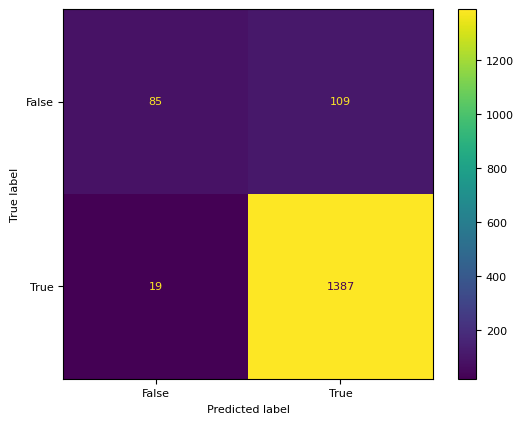

In [0]:
# Load the best model from the first MLflow experiment
best_model_uri = mlflow.search_runs(order_by=["metrics.test_f1_score DESC"]).iloc[0]["artifact_uri"] + "/model"
best_model = mlflow.sklearn.load_model(best_model_uri)

# Use the best model to predict
y_pred_best_model = best_model.predict(X_test)


# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_best_model)

# Display the confusion matrix
cmd = ConfusionMatrixDisplay(cm, display_labels=best_model.classes_)
cmd.plot()

**Model 2 Results**

[LightGBM] [Warning] lambda_l2 is set=3.3333333333333335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3333333333333335
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


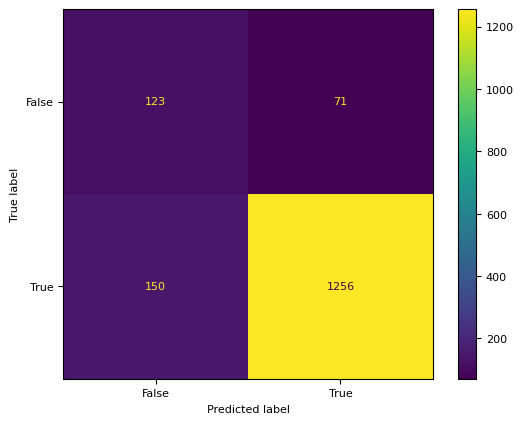

In [0]:
run_id = "5b40e1a4c7944d848e9e4b5948805ac5"
model_uri = f"runs:/{run_id}/model"

# Load the model
model = mlflow.pyfunc.load_model(model_uri)

# Assuming 'X_test' is your features dataset ready for prediction
predictions = model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display the confusion matrix
cmd = ConfusionMatrixDisplay(cm, display_labels=best_model.classes_)
cmd.plot()

**AutoML Model Results**

[LightGBM] [Warning] lambda_l2 is set=11.560017805648627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.560017805648627
[LightGBM] [Warning] lambda_l1 is set=0.2892876799108943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2892876799108943


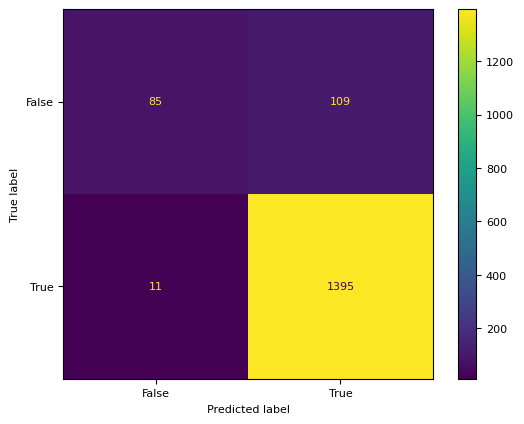

In [0]:
run_id = "039a2debf5f14d8984c8f9e19adfd998"
model_uri = f"runs:/{run_id}/model"

# Load the model
model = mlflow.pyfunc.load_model(model_uri)

# Assuming 'X_test' is your features dataset ready for prediction
predictions = model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display the confusion matrix
cmd = ConfusionMatrixDisplay(cm, display_labels=best_model.classes_)
cmd.plot()